In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install timm
!pip install scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import timm
import matplotlib.pyplot as plt


dataset_dir = "/content/drive/MyDrive/signaturesss"
# Paramètres
batch_size = 32
learning_rate = 0.0001
num_epochs = 80
num_folds = 2

# Transformations pour l'entraînement
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing()
])

# Chargement des données
dataset = ImageFolder(root=dataset_dir, transform=train_transform)
indices = np.arange(len(dataset))

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
print(indices)

[   0    1    2 ... 2645 2646 2647]


In [ ]:
# Boucle sur les plis
for fold, (trainval_ids, test_ids) in enumerate(kfold.split(indices)):
    # Séparation supplémentaire pour obtenir les sous-ensembles de train et de validation
    train_ids, val_ids = train_test_split(trainval_ids, test_size=0.2, random_state=42)

    print(f'FOLD {fold+1}')
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)
    test_subsampler = Subset(dataset, test_ids)

    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subsampler, batch_size=batch_size, shuffle=False)

    # Création du modèle
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Listes pour stocker les résultats pour chaque pli
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * running_correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Évaluation sur le sous-ensemble de validation
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_running_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_running_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Époque {epoch+1}, Perte Entraînement: {train_loss:.4f}, Précision Entraînement: {train_accuracy:.2f}%, '
              f'Perte Validation: {val_loss:.4f}, Précision Validation: {val_accuracy:.2f}%')

   # Sauvegarde du modèle après chaque pli
    model_save_path = f'/content/drive/MyDrive/Colab Notebooks/models/modele_t_fold{fold+1}.pth'
    torch.save(model.state_dict(), model_save_path)

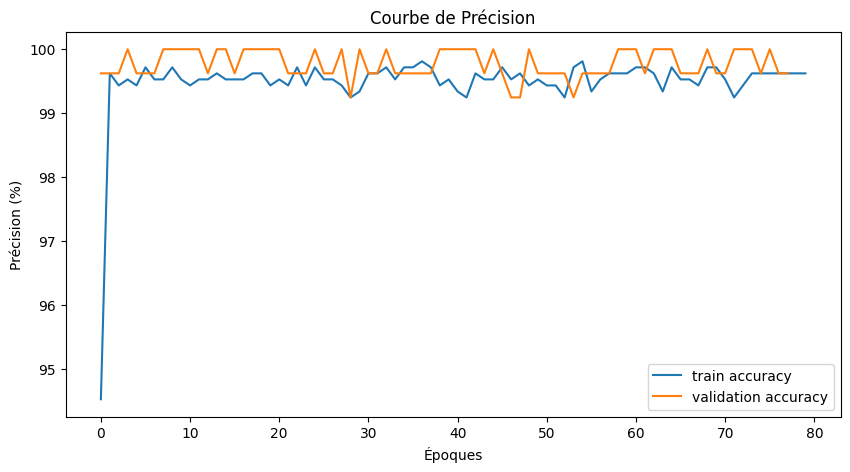

In [ ]:
# Courbe des précisions
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='train accuracy')

plt.plot(val_accuracies, label='validation accuracy')

plt.xlabel('Époques')
plt.ylabel('Précision (%)')
plt.title('Courbe de Précision')
plt.legend()
plt.show()

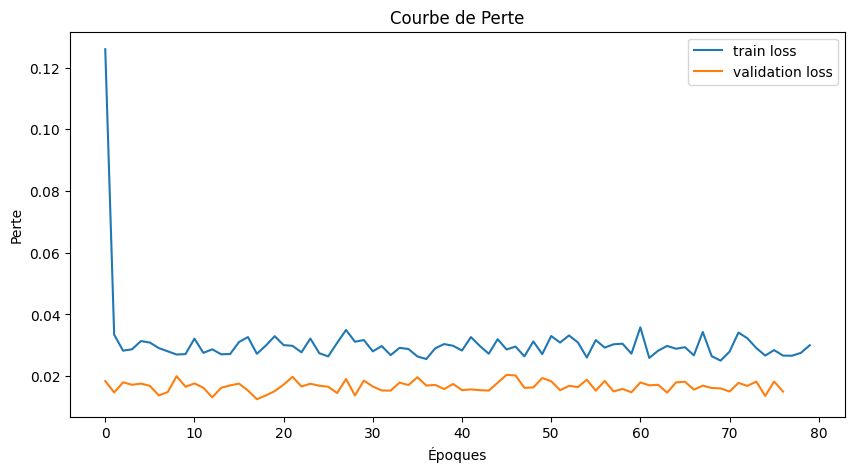

In [ ]:

# Courbe des pertes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbe de Perte')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_accuracies = []
y_true = []
y_pred = []
total=0
correct=0

# Évaluation du modèle
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Stocker les vrais labels et les prédictions pour le rapport de classification
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
test_accuracies.append(accuracy)

# Afficher l'exactitude
print(f'Test accuracy: {accuracy:.2f}%')

# Générer et afficher le rapport de classification
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Générer et afficher la matrice de confusion
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Test accuracy: 99.77%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       660
           1       1.00      1.00      1.00       664

    accuracy                           1.00      1324
   macro avg       1.00      1.00      1.00      1324
weighted avg       1.00      1.00      1.00      1324

Confusion Matrix:
[[657   3]
 [  0 664]]


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Assurez-vous que votre modèle est en mode d'évaluation et sur le bon dispositif
model.eval().to(device)  # où 'device' est 'cuda' si un GPU est disponible

# Chemin de l'image locale à tester
image_path = '/content/fch.jpg'
# Transformation à appliquer à l'image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionnement à 256x256
    transforms.CenterCrop(224),  # Rogner au centre à 224x224
    transforms.ToTensor(),  # Conversion en tenseur PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisation ImageNet
    # Note: Retirez les transformations aléatoires lors du test/prédiction
])

# Chargement et transformation de l'image
image = Image.open(image_path).convert('RGB')
image = transform(image)

# Ajout d'une dimension batch et déplacement sur le GPU
image = image.unsqueeze(0).to(device)  # Déplacement sur le GPU

# Prédiction
with torch.no_grad():
    outputs = model(image)
_, predicted = torch.max(outputs, 1)

# Affichage de la prédiction
print(f'Classe prédite: {predicted.item()}')


Classe prédite: 1
